# Example modeling process

### Imports

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import (get_training_observations, 
                     get_training_labels, 
                     get_protein_proportions)
import pandas as pd
import numpy as np

# Model specific imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import time

### Load training data and labels

In [4]:
x_train = get_training_observations()
y_train = get_training_labels()

Getting all training observations from 'metagenome_classification.db'...
Getting all training labels from 'metagenome_classification.db'...


In [5]:
x_train.head(10)

index,PF00001.19,PF00002.22,PF00003.20,PF00004.27,PF00005.25,PF00006.23,PF00007.20,PF00008.25,PF00009.25,PF00010.24,...,PF17216.1,PF17217.1,PF17218.1,PF17219.1,PF17220.1,PF17221.1,PF17222.1,PF17223.1,PF17224.1,PF17225.1
0,0.000000e+00,0.000000e+00,0.0,0.004020,0.006243,0.001039,0.0,0.000000,0.003265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000e+00,0.000000e+00,0.0,0.003575,0.013739,0.001026,0.0,0.000000,0.002235,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.376880e-07,2.188440e-07,0.0,0.001619,0.016218,0.000916,0.0,0.000002,0.001711,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000e+00,0.000000e+00,0.0,0.002737,0.019874,0.001785,0.0,0.000000,0.003570,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000e+00,0.000000e+00,0.0,0.001992,0.012389,0.001154,0.0,0.000013,0.002286,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000e+00,0.000000e+00,0.0,0.001684,0.016435,0.000931,0.0,0.000000,0.001806,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000e+00,0.000000e+00,0.0,0.001404,0.023274,0.000845,0.0,0.000000,0.001497,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000e+00,0.000000e+00,0.0,0.002301,0.015752,0.000925,0.0,0.000000,0.001843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000e+00,0.000000e+00,0.0,0.001885,0.014797,0.001012,0.0,0.000000,0.001689,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000e+00,0.000000e+00,0.0,0.004574,0.013601,0.000995,0.0,0.000000,0.002402,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
y_train.head()

index,EMPO_1,EMPO_2,EMPO_3
0,Free-living,Saline,Hypersaline (saline)
1,Free-living,Saline,Water (saline)
2,Host-associated,Plant,Plant rhizosphere
3,Free-living,Non-saline,Soil (non-saline)
4,Free-living,Saline,Water (saline)


### Data manipulation
Validation splits, dimensionality reduction, etc

In [60]:
lc = LabelEncoder()
y_train['EMPO_3'] = lc.fit_transform(y_train['EMPO_3'])
# Split into train/validation if not CV
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train['EMPO_3'], test_size=0.2, random_state=0)
# for hyperparameter tuning later
dtrain = xgb.DMatrix(x_tr, label=y_tr)
dval = xgb.DMatrix(x_val, label=y_val)

# Baseline

In [124]:
empo3_model = xgb.XGBClassifier(objective='multi:softmax',
                               eval_metric='mlogloss',
                               early_stopping_rounds = 10,
                               verbose=0)
baseline_results = {}
empo3_model.fit(x_tr,y_tr,
               eval_set=[(x_tr, y_tr), (x_val, y_val)],
               evals_result=baseline_results)
print(empo3_model)
# plot single tree
plot_tree(empo3_model)
plt.show()

TypeError: fit() got an unexpected keyword argument 'evals_result'

In [ ]:
empo3_pred = empo3_model.predict(x_val)
print("Training Set Accuracy Score on EMPO 3: ", accuracy_score(y_val, empo3_pred))

In [ ]:
results = empo3_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('MLogLoss')
plt.title('Baseline Model MLogLoss')
plt.show()
print(empo3_model.best_score)

### Model Tuning

For work here are the hyperparameters we usually try:
* model complexity:
    * max_depth: integers from 8 to 20
    * min_child_weight: integers from 1 to 100
    * gamma: float between 0 and 4
* randomness:
    * lambda/reg_lambda: log scaling .001 to 1
    * alpha/reg_alpha: log scaling .001 to 10
    * learning_rate: log scaling .01 to 1
    * subsample: float between 0.2 and 1
    * colsample_bytree, colsample_bylevel, colsample_bynode: for each, floats between 0.3 and 1

There are obviously a ton of different possible combinations here, so we use gridSearch pick the more important ones to test. I would just set learning rate at 0.01 and try changing the max_depth & min_child_weight parameters first.

accuracy|eta|colsample_bytree|gamma|max_depth|min_child_weight|reg_alpha|reg_lambda
--------|---|----------------|-----|---------|----------------|---|--
0.884 | 0.3 | 0.8166109190737193 | 1.3524019417422217 | 9 | 3 | 40 | 0.38875374236059673
0.92|0.3|0.7332967013192906|1.180637520546325|10|3|0.0|0.665768265241745
0.94|0.3|0.4718126556989784|1.1448126444222648|7|7|0.0|0.9968450328215387
0.92|0.6233550058931083|1.0|3.125965168028287|9|6|0.6278402276742281|2.750270104431137

In [135]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 5, 15, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
       'gamma': hp.uniform ('gamma', 1, 4),
       'reg_alpha' : hp.uniform('reg_alpha', 0, 100),
       'reg_lambda' : hp.uniform('reg_lambda', 0,5),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
       'n_estimators': 180, # same as num_boost_rounds
       'seed': 0,
       'random_state':0,
       'eta': hp.uniform('eta', 0,0.3),
       'objective':'multi:softmax',
       'num_class':15,
       'eval_metric':'mlogloss',
    }

# define objective function
def objective(space):
    clf=xgb.XGBClassifier(objective=space['objective'],
                          num_class=space['num_class'],
                          eval_metric=space['eval_metric'],
                          early_stopping_rounds=10,
                          n_estimators =space['n_estimators'],
                          max_depth = int(space['max_depth']), 
                          gamma = space['gamma'],
                          reg_alpha = int(space['reg_alpha']),
                          min_child_weight=int(space['min_child_weight']),
                          colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(x_tr, y_tr), (x_val, y_val)]
    # early stopping
    clf.fit(x_tr, y_tr,
            eval_set=evaluation,
           verbose=0)
    
    pred = clf.predict(x_val)
    accuracy = accuracy_score(y_val, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

# optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                                          
0.424                                                                           
SCORE:                                                                          
0.596                                                                           
SCORE:                                                                          
0.744                                                                           
SCORE:                                                                          
0.712                                                                           
SCORE:                                                                          
0.608                                                                           
SCORE:                                                                          
0.74                                                                            
SCORE:                      

0.408                                                                           
SCORE:                                                                          
0.508                                                                           
SCORE:                                                                          
0.604                                                                           
SCORE:                                                                          
0.816                                                                           
SCORE:                                                                          
0.836                                                                           
SCORE:                                                                          
0.892                                                                           
SCORE:                                                                          
0.84                        

SCORE:                                                                          
0.576                                                                           
SCORE:                                                                          
0.832                                                                           
SCORE:                                                                          
0.896                                                                           
SCORE:                                                                          
0.82                                                                            
SCORE:                                                                          
0.416                                                                           
SCORE:                                                                          
0.784                                                                           
SCORE:                      

0.824                                                                           
SCORE:                                                                          
0.86                                                                            
SCORE:                                                                          
0.832                                                                           
SCORE:                                                                          
0.9                                                                             
SCORE:                                                                          
0.912                                                                           
SCORE:                                                                          
0.828                                                                           
SCORE:                                                                          
0.912                       

### Model evaluation

[0]	train-mlogloss:2.57634	validation-mlogloss:2.57804
[1]	train-mlogloss:2.46150	validation-mlogloss:2.46324
[2]	train-mlogloss:2.35816	validation-mlogloss:2.36024
[3]	train-mlogloss:2.26120	validation-mlogloss:2.26801
[4]	train-mlogloss:2.17307	validation-mlogloss:2.18438
[5]	train-mlogloss:2.09178	validation-mlogloss:2.10854
[6]	train-mlogloss:2.01623	validation-mlogloss:2.03778
[7]	train-mlogloss:1.94657	validation-mlogloss:1.97274
[8]	train-mlogloss:1.88200	validation-mlogloss:1.91179
[9]	train-mlogloss:1.82138	validation-mlogloss:1.85504
[10]	train-mlogloss:1.76413	validation-mlogloss:1.80181
[11]	train-mlogloss:1.71068	validation-mlogloss:1.75104
[12]	train-mlogloss:1.65936	validation-mlogloss:1.70311
[13]	train-mlogloss:1.61102	validation-mlogloss:1.65767
[14]	train-mlogloss:1.56397	validation-mlogloss:1.61183
[15]	train-mlogloss:1.52019	validation-mlogloss:1.56748
[16]	train-mlogloss:1.47844	validation-mlogloss:1.52737
[17]	train-mlogloss:1.43840	validation-mlogloss:1.48891
[1

[146]	train-mlogloss:0.23927	validation-mlogloss:0.38610
[147]	train-mlogloss:0.23850	validation-mlogloss:0.38529
[148]	train-mlogloss:0.23798	validation-mlogloss:0.38473
[149]	train-mlogloss:0.23747	validation-mlogloss:0.38408
[150]	train-mlogloss:0.23665	validation-mlogloss:0.38320
[151]	train-mlogloss:0.23605	validation-mlogloss:0.38267
[152]	train-mlogloss:0.23567	validation-mlogloss:0.38227
[153]	train-mlogloss:0.23539	validation-mlogloss:0.38189
[154]	train-mlogloss:0.23521	validation-mlogloss:0.38161
[155]	train-mlogloss:0.23504	validation-mlogloss:0.38133
[156]	train-mlogloss:0.23487	validation-mlogloss:0.38105
[157]	train-mlogloss:0.23471	validation-mlogloss:0.38078
[158]	train-mlogloss:0.23455	validation-mlogloss:0.38052
[159]	train-mlogloss:0.23420	validation-mlogloss:0.38008
[160]	train-mlogloss:0.23331	validation-mlogloss:0.37919
[161]	train-mlogloss:0.23295	validation-mlogloss:0.37883
[162]	train-mlogloss:0.23281	validation-mlogloss:0.37859
[163]	train-mlogloss:0.23267	va

[290]	train-mlogloss:0.22610	validation-mlogloss:0.36646
[291]	train-mlogloss:0.22609	validation-mlogloss:0.36644
[292]	train-mlogloss:0.22609	validation-mlogloss:0.36642
[293]	train-mlogloss:0.22608	validation-mlogloss:0.36640
[294]	train-mlogloss:0.22608	validation-mlogloss:0.36638
[295]	train-mlogloss:0.22607	validation-mlogloss:0.36636
[296]	train-mlogloss:0.22606	validation-mlogloss:0.36634
[297]	train-mlogloss:0.22606	validation-mlogloss:0.36633
[298]	train-mlogloss:0.22605	validation-mlogloss:0.36631
[299]	train-mlogloss:0.22605	validation-mlogloss:0.36629
[300]	train-mlogloss:0.22604	validation-mlogloss:0.36627
[301]	train-mlogloss:0.22603	validation-mlogloss:0.36626
[302]	train-mlogloss:0.22603	validation-mlogloss:0.36624
[303]	train-mlogloss:0.22602	validation-mlogloss:0.36623
[304]	train-mlogloss:0.22602	validation-mlogloss:0.36621
[305]	train-mlogloss:0.22601	validation-mlogloss:0.36619
[306]	train-mlogloss:0.22601	validation-mlogloss:0.36618
[307]	train-mlogloss:0.22600	va

[434]	train-mlogloss:0.22549	validation-mlogloss:0.36506
[435]	train-mlogloss:0.22549	validation-mlogloss:0.36506
[436]	train-mlogloss:0.22549	validation-mlogloss:0.36505
[437]	train-mlogloss:0.22548	validation-mlogloss:0.36505
[438]	train-mlogloss:0.22548	validation-mlogloss:0.36504
[439]	train-mlogloss:0.22548	validation-mlogloss:0.36504
[440]	train-mlogloss:0.22548	validation-mlogloss:0.36504
[441]	train-mlogloss:0.22548	validation-mlogloss:0.36503
[442]	train-mlogloss:0.22548	validation-mlogloss:0.36503
[443]	train-mlogloss:0.22548	validation-mlogloss:0.36502
[444]	train-mlogloss:0.22548	validation-mlogloss:0.36502
[445]	train-mlogloss:0.22548	validation-mlogloss:0.36502
[446]	train-mlogloss:0.22547	validation-mlogloss:0.36501
[447]	train-mlogloss:0.22547	validation-mlogloss:0.36501
[448]	train-mlogloss:0.22547	validation-mlogloss:0.36501
[449]	train-mlogloss:0.22547	validation-mlogloss:0.36500
[450]	train-mlogloss:0.22547	validation-mlogloss:0.36500
[451]	train-mlogloss:0.22547	va

[578]	train-mlogloss:0.22538	validation-mlogloss:0.36466
[579]	train-mlogloss:0.22538	validation-mlogloss:0.36466
[580]	train-mlogloss:0.22538	validation-mlogloss:0.36466
[581]	train-mlogloss:0.22538	validation-mlogloss:0.36466
[582]	train-mlogloss:0.22538	validation-mlogloss:0.36466
[583]	train-mlogloss:0.22538	validation-mlogloss:0.36465
[584]	train-mlogloss:0.22538	validation-mlogloss:0.36465
[585]	train-mlogloss:0.22538	validation-mlogloss:0.36465
[586]	train-mlogloss:0.22538	validation-mlogloss:0.36465
[587]	train-mlogloss:0.22537	validation-mlogloss:0.36465
[588]	train-mlogloss:0.22537	validation-mlogloss:0.36465
[589]	train-mlogloss:0.22537	validation-mlogloss:0.36464
[590]	train-mlogloss:0.22537	validation-mlogloss:0.36464
[591]	train-mlogloss:0.22537	validation-mlogloss:0.36464
[592]	train-mlogloss:0.22537	validation-mlogloss:0.36464
[593]	train-mlogloss:0.22537	validation-mlogloss:0.36464
[594]	train-mlogloss:0.22537	validation-mlogloss:0.36464
[595]	train-mlogloss:0.22537	va

[722]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[723]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[724]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[725]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[726]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[727]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[728]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[729]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[730]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[731]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[732]	train-mlogloss:0.22533	validation-mlogloss:0.36447
[733]	train-mlogloss:0.22533	validation-mlogloss:0.36446
[734]	train-mlogloss:0.22533	validation-mlogloss:0.36446
[735]	train-mlogloss:0.22533	validation-mlogloss:0.36446
[736]	train-mlogloss:0.22533	validation-mlogloss:0.36446
[737]	train-mlogloss:0.22533	validation-mlogloss:0.36446
[738]	train-mlogloss:0.22533	validation-mlogloss:0.36446
[739]	train-mlogloss:0.22533	va

[866]	train-mlogloss:0.22531	validation-mlogloss:0.36438
[867]	train-mlogloss:0.22531	validation-mlogloss:0.36438
[868]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[869]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[870]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[871]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[872]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[873]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[874]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[875]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[876]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[877]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[878]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[879]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[880]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[881]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[882]	train-mlogloss:0.22531	validation-mlogloss:0.36437
[883]	train-mlogloss:0.22531	va

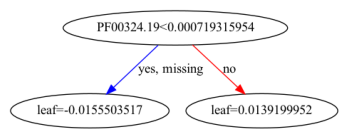

Best Multiclass Log Loss: 0.36 with 999 rounds


In [140]:
best_params = {
    # tuned parameters
    'colsample_bytree': 1.0, 
    'eta': 0.03, 
    'gamma': 3.125965168028287, 
    'max_depth': 9, 
    'min_child_weight': 6, 
    'reg_alpha': 0.6278402276742281, 
    'reg_lambda': 2.750270104431137,
    # other parameters
    'objective':'multi:softmax',
    'num_class':15,
    'eval_metric':['mlogloss'],
}
evals_result = {}
best_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round = 999,
    evals=[(dtrain, "train"), (dval, "validation")],
    evals_result=evals_result,
    early_stopping_rounds=6,
)
# plot single tree
plot_tree(best_model)
plt.show()
print("Best Multiclass Log Loss: {:.2f} with {} rounds".format(
                 best_model.best_score,
                 best_model.best_iteration+1))

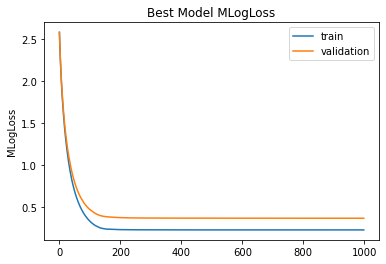

In [142]:
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['mlogloss'], label='train')
ax.plot(x_axis, evals_result['validation']['mlogloss'], label='validation')
ax.legend()
plt.ylabel('MLogLoss')
plt.title('Best Model MLogLoss')
plt.show()

In [143]:
y_pred = best_model.predict(xgb.DMatrix(x_val))
print("Best model accuracy:", accuracy_score(y_val, y_pred))

Best model accuracy: 0.92


### Retrain best model
After experimenting with models, retrain your favorite model using entire training set (including validation) before saving

[0]	train-merror:0.04104	validation-merror:0.94000
[1]	train-merror:0.01401	validation-merror:0.95200
[2]	train-merror:0.00801	validation-merror:0.94000
[3]	train-merror:0.00601	validation-merror:0.94400
[4]	train-merror:0.00200	validation-merror:0.94000


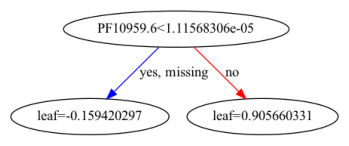

Best Multiclass Log Loss: 0.94 with 1 rounds


In [19]:
d_train = xgb.DMatrix(x_train, label=y_train['EMPO_3'])

evals_result = {}
num_boost_round = 999
best_model = xgb.train(
    best_params, 
    d_train,
    num_boost_round = num_boost_round,
    evals=[(d_train, "full-train")],
    evals_result=evals_result,
    early_stopping_rounds=10
)
# plot single tree
plot_tree(best_model)
plt.show()
print("Best Multiclass Log Loss: {:.2f} with {} rounds".format(
                 best_model.best_score,
                 best_model.best_iteration+1))

epochs = len(evals_result['full-train']['mlogloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['full-train']['mlogloss'], label='train')
ax.legend()
plt.ylabel('MLogLoss')
plt.title('Best Model MLogLoss')
plt.show()

### Save fitted model

In [145]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
from joblib import dump

dump(best_model, '../model_joblibs/xgb_empo3.joblib')

['../model_joblibs/xgb_empo3.joblib']